In [166]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess


In [167]:
channel_name = "channel_1055"
df = pd.read_csv(f'../../data/{channel_name}.csv', index_col="Timestamp", parse_dates=True)

In [168]:
df.head()

,channel_1055,Unit_measure,Subsystem
Timestamp,,,
2025-01-01 00:00:00,0.496714,UnitMeasure5,Subsystem1
2025-01-01 00:00:30,0.904835,UnitMeasure5,Subsystem1
2025-01-01 00:01:00,1.698462,UnitMeasure5,Subsystem1
2025-01-01 00:01:30,3.863408,UnitMeasure5,Subsystem1
2025-01-01 00:02:00,5.621446,UnitMeasure5,Subsystem1


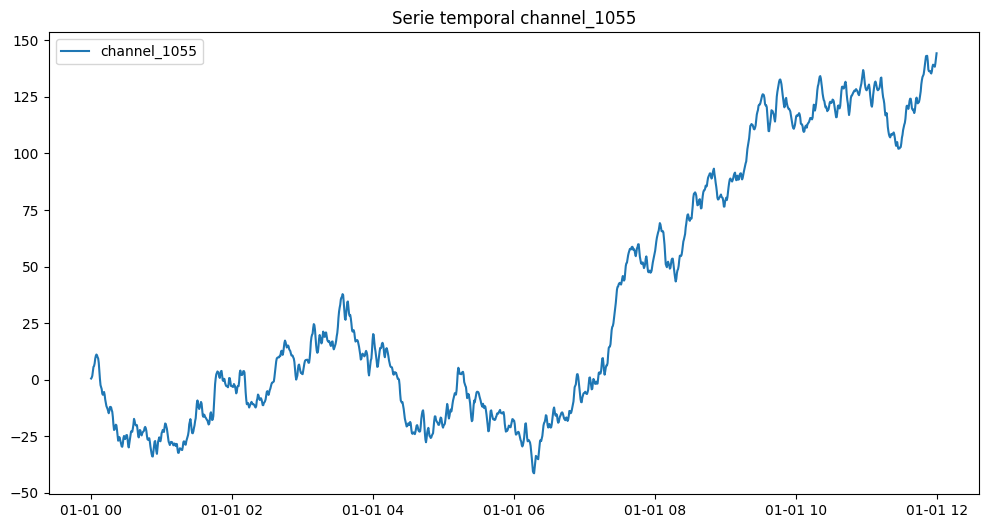

In [169]:
plt.figure(figsize=(12,6))
plt.plot(df["channel_1055"], label=channel_name)
plt.title(f'Serie temporal {channel_name}')
plt.legend()
plt.show()



¿Hay nulos?

In [170]:
#Si, columnas hay una sola, pero lo dejamos genérico para otros casos
for c in df.columns:
    print(f"{c}: {df[c].isnull().sum()} nulos")

channel_1055: 0 nulos
Unit_measure: 0 nulos
Subsystem: 0 nulos


¿Hay duplicados?

In [171]:
df.index.duplicated().any() 

False

¿La periodicidad es estable?

In [172]:
df_time_diffs = df.index.to_series().diff().dt.total_seconds()  
print(df_time_diffs.value_counts())

Timestamp
30.0    1353
60.0      43
Name: count, dtype: int64


---------------------

### 1. Si la periodicidad no es estable, resolver



### 2. ¿Tiene la serie propiedades para poder aplicar un modelo estadístico? Si no las tiene resolver.

### 3. ¿Puede encontrar un modelo que supere el pronostico ingenuo que agregamos a continuación?

### 4. Si a realizar una búsqueda de órden p y q ¿Puede restringir al menos un poco las opciones de búsqueda?

In [173]:
ndf = df.copy() 
ndf = ndf.asfreq("30s", method=None)
ndf[f'{channel_name}_ffill'] = df[channel_name].asfreq("30s", method="ffill")
ndf[f'{channel_name}_none'] = df[channel_name].asfreq("30s", method=None)
ndf[f'{channel_name}_interpolated'] = ndf[f'{channel_name}_none'].interpolate(method='linear')

Me quedo con el interpolado...

In [174]:
df = ndf[[f'{channel_name}_interpolated']].copy()
df[channel_name] = df[f'{channel_name}_interpolated']
df.drop(columns=[f'{channel_name}_interpolated'], inplace=True)

¿Es estacionaria?

In [175]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [176]:
ADF_result = adfuller(df[channel_name])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 0.1739766952883364
p-value: 0.9707636698019284


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto la serie no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [177]:
df.loc[:,['values_diff']] = df[channel_name].diff()
df_diff1 = df.copy()
#Eliminamos el nulo del inicio
df_diff1.dropna(inplace=True)

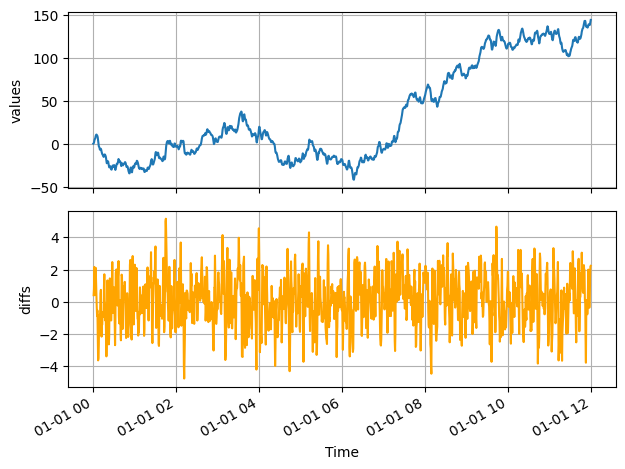

In [178]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df[channel_name])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)
ax1.grid()
ax2.plot(df['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
ax2.grid()
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

Vuelvo a chequear si es estacionaria...

In [179]:
ADF_result = adfuller(df_diff1["values_diff"])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -15.524232459491365
p-value: 2.263044887157599e-28


Ahora analizo ACF, PACF

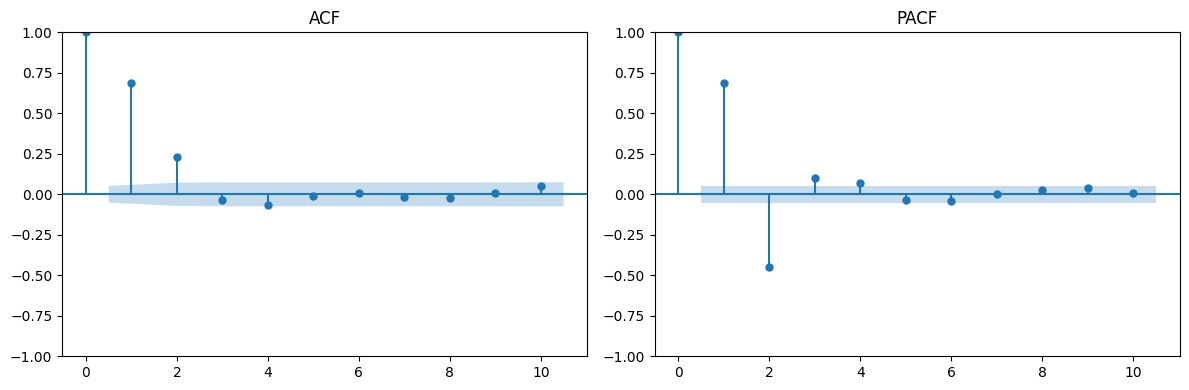

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF
plot_acf(df_diff1["values_diff"], ax=axes[0], lags=10, alpha=0.05)
axes[0].set_title("ACF")

# PACF
plot_pacf(df_diff1["values_diff"], ax=axes[1], lags=10, alpha=0.05, method="ywm")
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

Me quedo con d=1, p posiblemente 2, q posiblemente 2

In [181]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
ps = range(1, 3, 1)    
qs = range(1, 3, 1)
ds = range(1, 2, 1)
#Producto cartesiano de los valores de p y q
# Esto genera todas las combinaciones posibles de p y q
order_list = list(product(ps,ds,qs))

In [182]:
ldf = df_diff1.copy()
train_len = int(ldf.shape[0]*0.9)
test_len = ldf.shape[0] - train_len
train = ldf[:train_len]
test = ldf[train_len:]
results = []
for p, d, q in order_list:
    try:
        model = SARIMAX(train['values_diff'], order=(p, d, q), simple_differencing=False)
        model_fit = model.fit(disp=False)
    except:
        print(f"Error with order ({p}, {d}, {q}), skipping...")
        continue
    aic = model_fit.aic
    results.append([(p,d,q), aic])

In [183]:
result_df = pd.DataFrame(results)
result_df.columns = ['(p,d,q)', 'AIC']
#Sort in ascending order, lower AIC is better
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
result_df.loc[:5,:]

,"(p,d,q)",AIC
0,"(2, 1, 2)",3732.627613
1,"(2, 1, 1)",3738.257143
2,"(1, 1, 2)",3793.578540
3,"(1, 1, 1)",4125.724468


In [184]:
p, d, q = result_df.loc[0].values[0]
model = SARIMAX(train[channel_name], order=(p,d,q), simple_differencing=False)
model_fit = model.fit(disp=False)
#print(model_fit.summary())

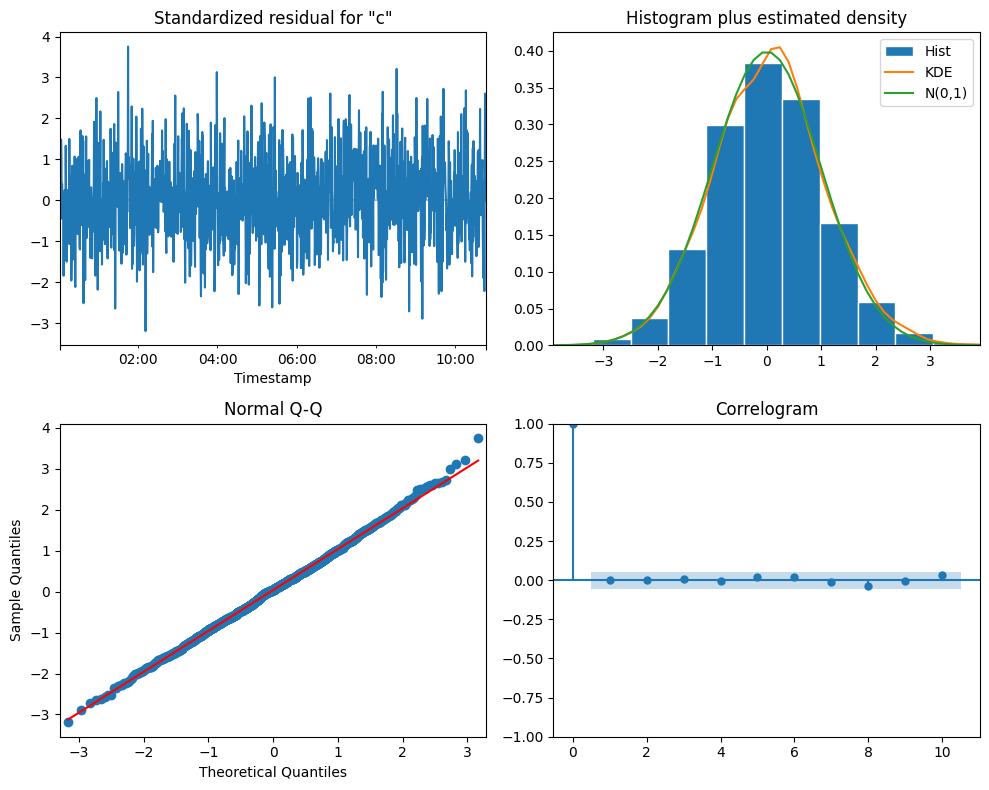

In [185]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

Me quedo con p=2, d=1, q=2

In [186]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
print(f'TRAIN_LEN: {TRAIN_LEN}, HORIZON: {HORIZON}, WINDOW: {WINDOW}')

TRAIN_LEN: 1295, HORIZON: 144, WINDOW: 1


In [214]:
def pred_last_value(train, test, window=1):
    pred_last_value = []
        
    train_len = len(train)
    total_len = train_len + len(test)
    for i in range(train_len, total_len, window):
        last_value = df[:i].iloc[-1].values[0]
        pred_last_value.extend(last_value for _ in range(window))
            
    
    return pred_last_value

def pred_sarimax(train, test, order=(1, 0, 0), window=1, horizon=1):
    pred_sarimax = []
        
    train_len = len(train)
    total_len = train_len + horizon
    df = pd.concat([train, test])
    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=order, seasonal_order=(0, 0, 0, 0))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_sarimax.extend(oos_pred)


    
    return pred_sarimax

In [215]:
order = (2, 1, 2)
test.loc[:, ["pred_sarimax"]] = pred_sarimax(train=train.loc[:, [channel_name]], 
                                             test=test.loc[:, [channel_name]], 
                                             order=order, 
                                             window=WINDOW,
                                             horizon=len(test))

In [216]:
test.loc[:, ["pred_last_value"]] = pred_last_value(train=train, test=test, window=WINDOW)

Veamos los plots....

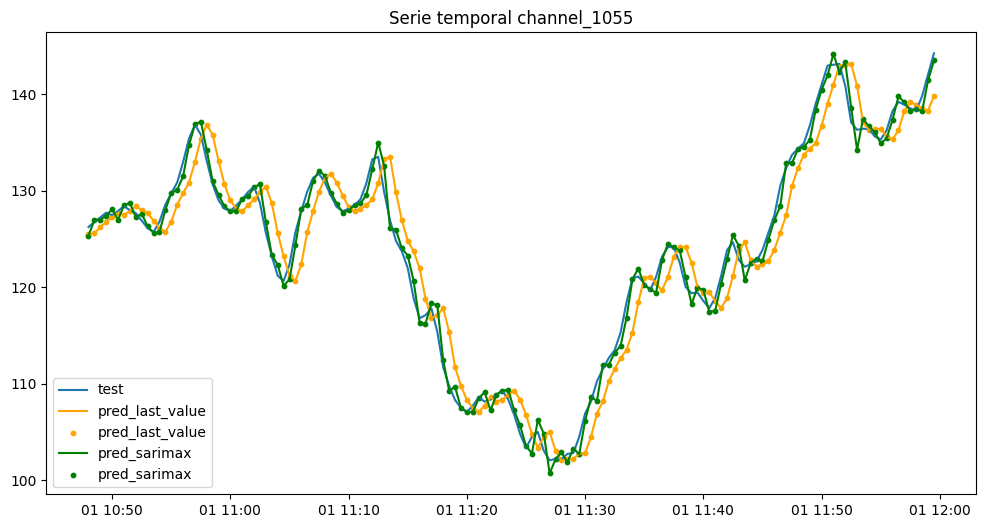

In [217]:
plt.figure(figsize=(12,6))
plt.plot(test[channel_name], label='test')
plt.plot(test['pred_last_value'], label='pred_last_value', color='orange')
plt.scatter(test.index, test['pred_last_value'],  color='orange', label='pred_last_value', s=10)
plt.plot(test['pred_sarimax'], label='pred_sarimax', color='green')
plt.scatter(test.index, test['pred_sarimax'],  color='green', label='pred_sarimax', s=10)
plt.legend()    
plt.title(f'Serie temporal {channel_name}') 
plt.show()

Calculemos el error de ambas predicciones.

In [220]:
print("MAE de last value: {:.2f}".format((test[channel_name] - test['pred_last_value']).abs().mean()))
print("MAE de SARIMAX: {:.2f}".format((test[channel_name] - test['pred_sarimax']).abs().mean()))


MAE de last value: 2.33
MAE de SARIMAX: 0.77


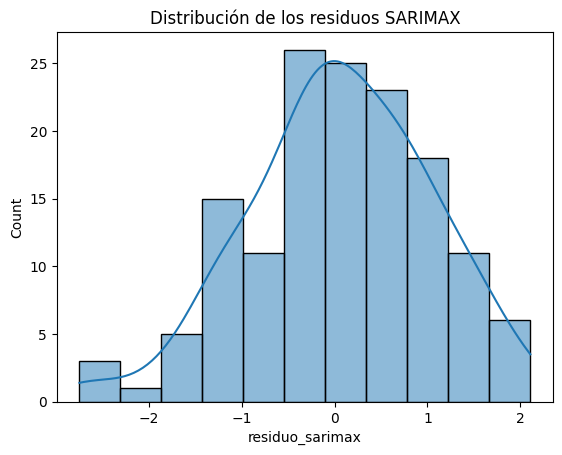

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
test.loc[:, ["residuo_sarimax"]] = test[channel_name] - test['pred_sarimax']
test.loc[:, ["residuo_last_value"]] = test[channel_name] - test['pred_last_value']

sns.histplot(test["residuo_sarimax"], kde=True)
plt.title("Distribución de los residuos SARIMAX")
plt.show()

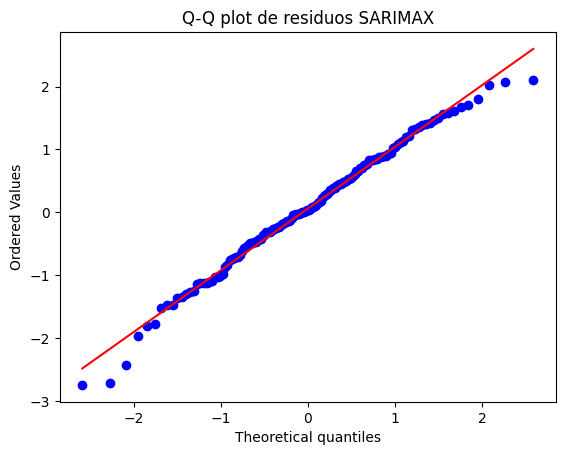

In [223]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(test["residuo_sarimax"], dist="norm", plot=plt)
plt.title("Q-Q plot de residuos SARIMAX")
plt.show()

test de normalidad

In [224]:
from scipy.stats import shapiro

stat, p = shapiro(test["residuo_sarimax"])
print("Shapiro-Wilk Test → estadístico=%.3f, p=%.3f" % (stat, p))

if p > 0.05:
    print("No se rechaza H0 → residuos ~ normales")
else:
    print("Se rechaza H0 → residuos NO ~ normales")

Shapiro-Wilk Test → estadístico=0.990, p=0.363
No se rechaza H0 → residuos ~ normales
